In [6]:
# ============================================
# ⚽ Premier League Assists Prediction Model
# ============================================

# 1️⃣ Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder




In [7]:
# ============================================
# 2️⃣ Load Dataset
# ============================================

# Load data
df = pd.read_csv("/content/topassist.csv")

print("✅ Data Loaded Successfully")
print("Shape of dataset:", df.shape)
print("\n📄 Sample Data:\n", df.head())


✅ Data Loaded Successfully
Shape of dataset: (320, 24)

📄 Sample Data:
     Season  Rank           Player              Club  Age    Position  \
0  2023-24     1    Ollie Watkins       Aston Villa   28     Forward   
1  2023-24     2      Cole Palmer           Chelsea   22  Midfielder   
2  2023-24     3   Anthony Gordon  Newcastle United   23      Winger   
3  2023-24     4  Kevin De Bruyne   Manchester City   32  Midfielder   
4  2023-24     5      Pascal Groß          Brighton   33  Midfielder   

   Minutes_Played  Assists_prev_season  Goals_prev_season  Assists  ...  \
0            3350                 15.0               14.0       13  ...   
1            2985                  3.0                3.0       11  ...   
2            2954                  2.0               11.0       10  ...   
3            1121                 16.0                7.0       10  ...   
4            3241                  8.0                9.0       10  ...   

   Shots_Assisted  Set_Piece_Involvement  Cl

In [8]:
# ============================================
# 3️⃣ Data Quality Check
# ============================================

print("\n🔍 Checking Missing Values:\n", df.isnull().sum())

# Fill numeric NaN with median, categorical NaN with mode
for col in df.columns:
    if df[col].dtype == "object":
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].median(), inplace=True)

# Remove duplicates
df.drop_duplicates(inplace=True)

print("\n✅ Missing values handled successfully")
print("Dataset shape after cleaning:", df.shape)


🔍 Checking Missing Values:
 Season                     0
Rank                       0
Player                     0
Club                       0
Age                        0
Position                   0
Minutes_Played             0
Assists_prev_season      108
Goals_prev_season         88
Assists                    0
Key_Passes                 0
Expected_Assists_(xA)      0
Crosses_Completed        320
Dribbles_Completed         0
Shots_Assisted             0
Set_Piece_Involvement      0
Club_Total_Goals           0
Club_League_Rank           0
Big6_Club_Feature          0
Club_Attack_Share          0
Club_xG                    0
Assists_per_90             0
xA_per_90                  0
Key_Passes_per_90          0
dtype: int64

✅ Missing values handled successfully
Dataset shape after cleaning: (320, 24)


/tmp/ipython-input-2135638871.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)
/tmp/ipython-input-2135638871.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try u


📈 Starting EDA...


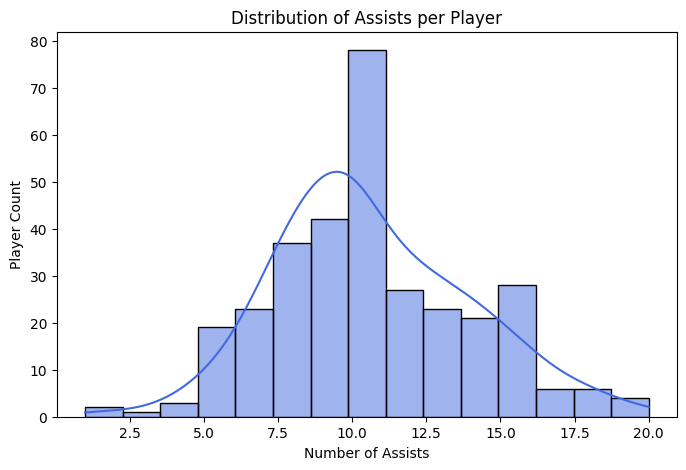

In [9]:
# ============================================
# 4️⃣ Exploratory Data Analysis (EDA)
# ============================================

print("\n📈 Starting EDA...")

# ---- Plot 1: Distribution of Target Variable ----
plt.figure(figsize=(8,5))
sns.histplot(df["Assists"], kde=True, color="royalblue", bins=15)
plt.title("Distribution of Assists per Player")
plt.xlabel("Number of Assists")
plt.ylabel("Player Count")
plt.show()

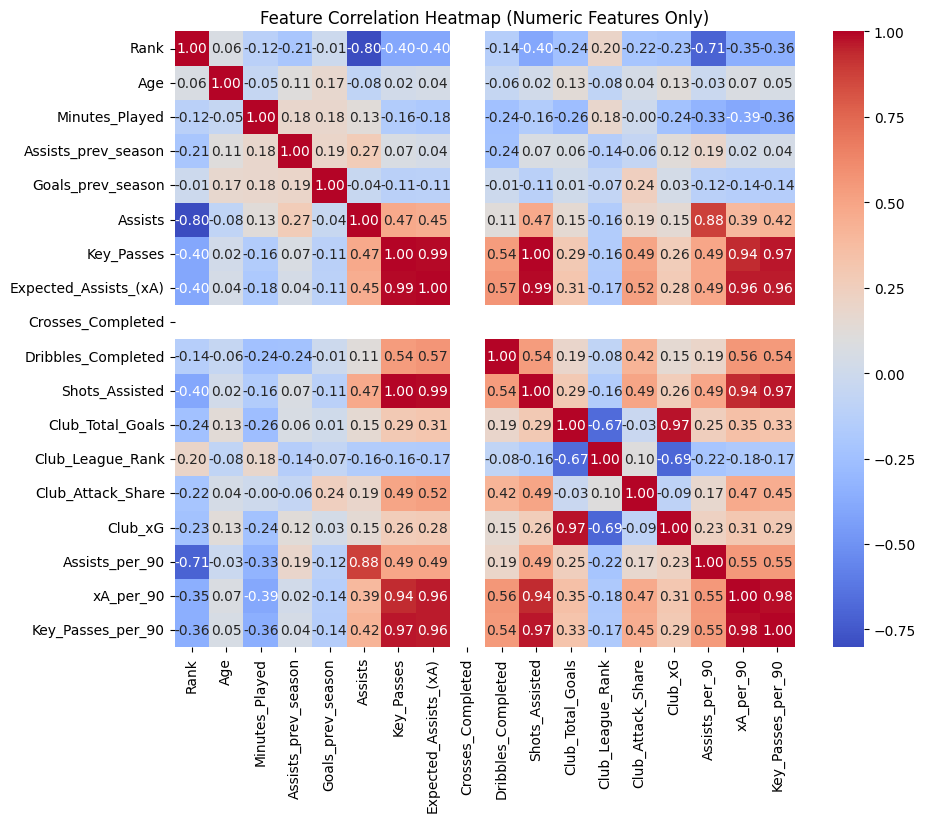

In [10]:
# ---- Plot 2: Correlation Heatmap ----
plt.figure(figsize=(10,8))
corr = df.select_dtypes(include=['number']).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap (Numeric Features Only)")
plt.show()

/tmp/ipython-input-3218494489.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Position", y="Assists", data=df, palette="Set2")


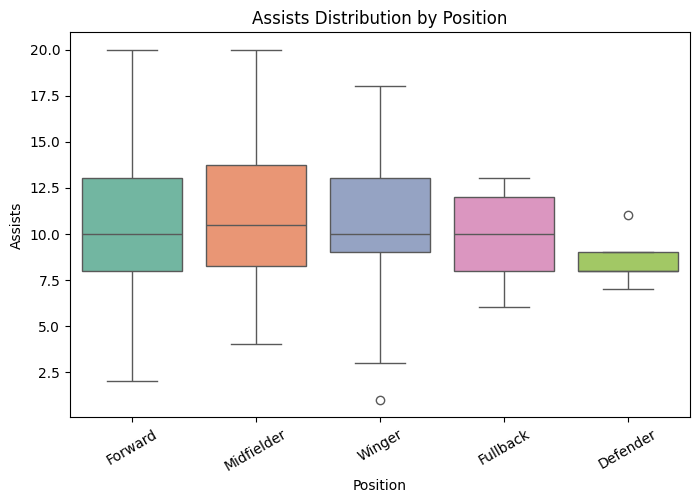

In [11]:
# ---- Plot 3: Assists by Position ----
if "Position" in df.columns:
    plt.figure(figsize=(8,5))
    sns.boxplot(x="Position", y="Assists", data=df, palette="Set2")
    plt.title("Assists Distribution by Position")
    plt.xticks(rotation=30)
    plt.show()

/tmp/ipython-input-3459449250.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Assists", y="Player", data=top_players, palette="viridis")


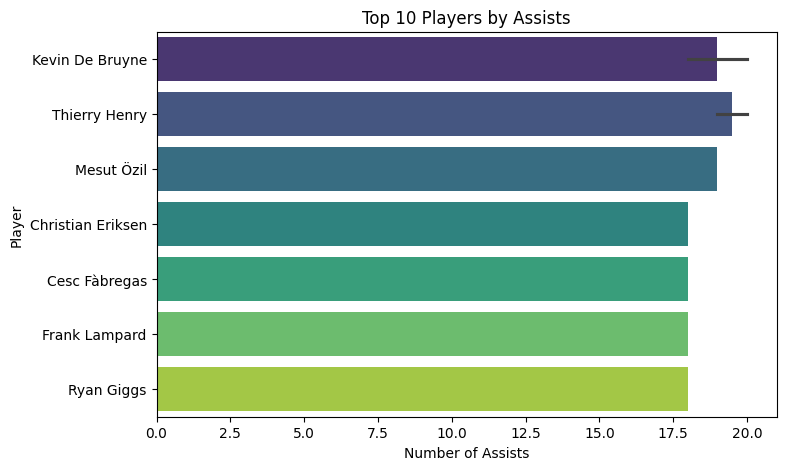


✅ EDA Completed Successfully!


In [12]:
# ---- Plot 4: Top 10 Players by Assists ----
if "Player" in df.columns:
    top_players = df.nlargest(10, "Assists")[["Player", "Assists"]]
    plt.figure(figsize=(8,5))
    sns.barplot(x="Assists", y="Player", data=top_players, palette="viridis")
    plt.title("Top 10 Players by Assists")
    plt.xlabel("Number of Assists")
    plt.ylabel("Player")
    plt.show()

print("\n✅ EDA Completed Successfully!")

In [13]:
# ============================================
# 5️⃣ Feature Preparation
# ============================================

# Encode categorical columns automatically
label_encoders = {}
for col in df.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Drop unnecessary identifiers if present
drop_cols = ["Player", "Season"]
df_model = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

# Split data
X = df_model.drop("Assists", axis=1)
y = df_model["Assists"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("\n🧠 Data Split Done:")
print("Train Size:", X_train.shape)
print("Test Size:", X_test.shape)




🧠 Data Split Done:
Train Size: (256, 21)
Test Size: (64, 21)


In [14]:
# ============================================
# 6️⃣ Model Training
# ============================================

rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    max_depth=10,
    min_samples_split=5
)
rf.fit(X_train, y_train)



RandomForestRegressor(max_depth=10, min_samples_split=5, n_estimators=200,
                      random_state=42)

In [15]:
# ============================================
# 7️⃣ Model Evaluation
# ============================================

y_pred = rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\n📊 Model Evaluation Results:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.3f}")



📊 Model Evaluation Results:
Mean Squared Error (MSE): 0.44
Root Mean Squared Error (RMSE): 0.67
R² Score: 0.964


/tmp/ipython-input-3617995551.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances.values, y=feature_importances.index, palette="cool")


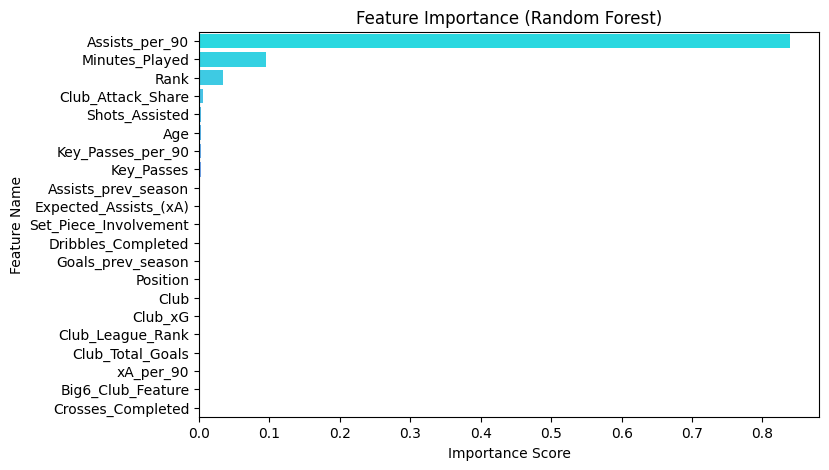


🏁 Analysis Complete – Model Training & Evaluation Successful!


In [16]:
# ============================================
# 8️⃣ Feature Importance Visualization
# ============================================

feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=feature_importances.values, y=feature_importances.index, palette="cool")
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.show()

print("\n🏁 Analysis Complete – Model Training & Evaluation Successful!")